<a href="https://colab.research.google.com/github/AnjanDutta/EEEM068/blob/main/Notebooks/Human_Action_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<H1 style="text-align: center">EEEM068 - Applied Machine Learning</H1>
<H1 style="text-align: center">Workshop 05</H1>
<H1 style="text-align: center">Human Action Recognition Tutorial</H1>



## Introduction

In this tutorial, we will explore 2D and 3D convolutional neural network models in recognizing human actions occurring in the videos from the [KTH dataset](https://www.csc.kth.se/cvap/actions/).

## KTH Dataset
The KTH dataset consists of videos of humans performing 6 types of action: *boxing*, *clapping*, *waving*, *jogging*, *running*, and *walking*. There are 25 subjects performing these actions in 4 scenarios: outdoor, outdoor with scale variation, outdoor with different clothes, and indoor. The total number of videos is therefore $25 \times 4 \times 6 = 600$. The videos' frame rate are 25fps and their resolution is $160 \times 120$. More information about the dataset can be looked up at the website. More details on this dataset can be found at https://www.csc.kth.se/cvap/actions.

We have preprocessed (i.e., extracted the frames and resized those frames etc) those videos and pickled them in the following link (https://empslocal.ex.ac.uk/people/staff/ad735/ECMM426/KTH_pickle.zip). In this experiment, we will be using the pickled version of the KTH dataset. However, the raw KTH videos can be found in this link (https://empslocal.ex.ac.uk/people/staff/ad735/ECMM426/KTH.zip).

<img src="http://www.csc.kth.se/cvap/actions/actions.gif" alt="action recognition" width="500"/>

Lets download the pickled dataset from the above link.

In [12]:
# Download the dataset
import os
if not os.path.exists('KTH_pickle.zip'):
  !wget --no-check-certificate https://empslocal.ex.ac.uk/people/staff/ad735/ECMM426/KTH_pickle.zip
  !unzip -q KTH_pickle.zip

# Dictionary of categories
CATEGORY_INDEX = {
    "boxing": 0,
    "handclapping": 1,
    "handwaving": 2,
    "jogging": 3,
    "running": 4,
    "walking": 5
}

### Example Video

Lets plot 20 equidistant frames of the very first video in the train split.

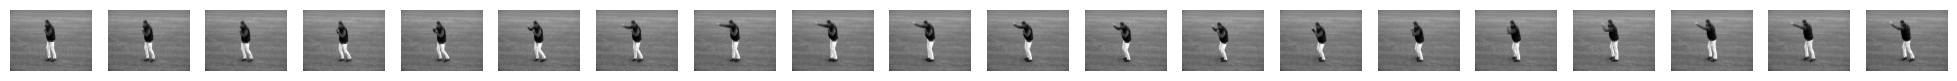

Action class: boxing


In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
videos = pickle.load(open('KTH_pickle/train.pickle', 'rb'))
# first video
video_0 = videos[0]['frames']
# number of frames
n = 20
# figure size
fig = plt.figure(figsize=(25, 25))
# index of equidistant frames
nth_frames = np.linspace(0, len(video_0) - 1, n).astype(int)
for i in range(n):
    frame = video_0[i]
    fig.add_subplot(1, n, i + 1)
    plt.imshow(frame, cmap='gray')
    plt.axis('off')
plt.show()

print('Action class: ' + videos[0]['category'])

Now lets plot 20 equidistant frames of the 91st video in the train split

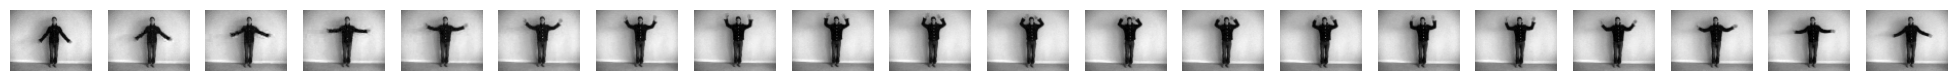

Action class: handwaving


In [3]:
# tenth video
video_90 = videos[90]['frames']
# number of frames
n = 20
# figure size
fig = plt.figure(figsize=(25, 25))
# index of equidistant frames
nth_frames = np.linspace(0, len(video_90) - 1, n).astype(int)
for i in range(n):
    frame = video_90[i]
    fig.add_subplot(1, n, i + 1)
    plt.imshow(frame, cmap='gray')
    plt.axis('off')
plt.show()

print('Action class: ' + videos[90]['category'])

### Dataset and DataLoader
Since KTH dataset is not available within the torchvision's collection of datasets, we have to create our own dataset class to train an action recognition model. As discussed in the lecture, we will build two different models for that. The first one is based on 2D CNN, which will consider each frame as an image and will classify each frame into one of the action classes. Therefore, this model will work as an image classification model rather than a video classification model. For the second model, we will use 3D CNN which will consider a sequence or block of frames and intend to classify the entire sequence of frames into one of the action classes. In contrast with the first model, the second model will consider temporal information and will act as a true action recognition model.

Therefore, in order to feed appropriate data, we will design two different types of dataset: (1) **SingleFrameDataset:** the first will return single frame which we will consider as an individual image, (2) **BlockFrameDataset:** block or sequence of frames where temporal information will be considered. Below, we have the two datasets for in PyTorch format.

#### Single frame dataset

This dataset is used for training the single frame model.

In [5]:
import os
import torch
import pickle
import numpy as np
from torch.utils.data import Dataset

class SingleFrameDataset(Dataset):
    def __init__(self, directory, dataset="train"):
        self.instances, self.labels = self.read_dataset(directory, dataset)
        # convert them into tensor
        self.instances = torch.from_numpy(self.instances)
        self.labels = torch.from_numpy(self.labels)
        # normalize
        self.zero_center()

    def __len__(self):
        return self.instances.shape[0]

    def __getitem__(self, idx):
        return self.instances[idx], self.labels[idx]

    def zero_center(self):
        self.instances -= float(self.mean)

    def read_dataset(self, directory, dataset="train"):
        # set paths according to split
        if dataset == "train":
            filepath = os.path.join(directory, "train.pickle")
        elif dataset == "val":
            filepath = os.path.join(directory, "val.pickle")
        else:
            filepath = os.path.join(directory, "test.pickle")
        #read the pickle file
        videos = pickle.load(open(filepath, "rb"))
        # accumulate the instances and label
        instances = []
        labels = []
        for video in videos:
            for frame in video["frames"]:
                instances.append(frame.reshape((1, 60, 80)))
                labels.append(CATEGORY_INDEX[video["category"]])
        # numpy array
        instances = np.array(instances, dtype=np.float32)
        labels = np.array(labels, dtype=np.uint8)
        self.mean = np.mean(instances)
        return instances, labels

#### Block Frame Dataset

This dataset is used for training the block frame model.

In [6]:
import os
import torch
import pickle
import numpy as np
from torch.utils.data import Dataset

class BlockFrameDataset(Dataset):
    def __init__(self, directory, dataset="train"):
        self.instances, self.labels = self.read_dataset(directory, dataset)
        # convert them into tensor
        self.instances = torch.from_numpy(self.instances)
        self.labels = torch.from_numpy(self.labels)
        # normalize
        self.zero_center()

    def __len__(self):
        return self.instances.shape[0]

    def __getitem__(self, idx):
        return self.instances[idx], self.labels[idx]

    def zero_center(self):
        self.instances -= float(self.mean)

    def read_dataset(self, directory, dataset="train", mean=None):
        # set paths according to split
        if dataset == "train":
            filepath = os.path.join(directory, "train.pickle")
        elif dataset == "val":
            filepath = os.path.join(directory, "val.pickle")
        else:
            filepath = os.path.join(directory, "test.pickle")
        # read the pickle file
        videos = pickle.load(open(filepath, "rb"))
        # accumulate the instances and label
        instances = []
        labels = []
        current_block = []
        for video in videos:
            for i, frame in enumerate(video["frames"]):
                current_block.append(frame)
                # 15 consecutive frames
                if len(current_block) % 15 == 0:
                    current_block = np.array(current_block)
                    instances.append(current_block.reshape((1, 15, 60, 80)))
                    current_block = []
                    labels.append(CATEGORY_INDEX[video["category"]])
        # numpy array
        instances = np.array(instances, dtype=np.float32)
        labels = np.array(labels, dtype=np.uint8)
        self.mean = np.mean(instances)
        return instances, labels

## Models

As mentioned above, we will create two different models. (1) **SingleFrameModel:** the first one is based on 2D CNN, which will consider each single frame as an image and will classify each frame into one of the action classes. In other words, this model will work as an image classification model rather than a video classification model, because it will not consider any temporal information. (2) **BlockFrameModel:** the second model we will use 3D CNN which will consider a sequence or block of frames and intend to classify the entire sequence of frames into one of the action classes. In contrast with the first model, the second model will consider temporal information and will act as a true action recognition model. Therefore, it is expected that the BlockFrameModel works better than the SingleFrameModel for the action classification task.

### Single Frame Model

Below we implement the single frame model. If this model is tested after training it for 20 epochs, the accuracy of this model on the test set should be around 55%. This accuracy could be increased if you train it longer. In this model, we are going to use the following functions or modules:

* `nn.Sequential()`: It is a sequential container. Modules will be added to it in the order they are passed in the constructor. Please check the [documentation](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html#torch.nn.Sequential) for more details.

* `nn.Conv2d()`: It is a PyTorch module that applies a 2D convolution over an input signal composed of several input planes. More details are available on the [documentation](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html).

* `nn.BatchNorm2d()`: This module applies batch normalization over a 4D input as described in the [Batch Normalization paper](https://arxiv.org/abs/1502.03167). More details can be found in the [documentation](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html).

* `nn.MaxPool2d()`: It is also a module that applies a 2D max pooling over an input signal composed of several input planes. Please have a look on this [documentation](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) for more details.

* `nn.Linear()`: It is a module that applies a linear transformation to the incoming data. More details can be found in its [documentation](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#linear).

* `nn.ReLU()`: It is also a module that applies element-wise the rectified linear unit function. Its [documentation](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#relu) can explain more.

* `nn.Dropout()`: This module randomly zeroes some of the elements of the input tensor with probability `p`. Check the [documentation](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html#dropout) for more details.

In [7]:
import torch.nn as nn

class SingleFrameModel(nn.Module):
    def __init__(self, n_classes):
        super(SingleFrameModel, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.5),
            nn.Conv2d(16, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.5),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.5))

        self.fc = nn.Sequential(
            nn.Linear(2560, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, n_classes))

    def forward(self, x):
        out = self.conv(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)

        return out

### Block Frame Model
Below we implement the 2nd model that considers sequence of frames. For each video, we devide it into blocks of 15 contiguous frames. The model is then trained on these blocks instead of individual frame. In the convolutional layers, we use 3D convolutional filters (i.e. 3D CNN) to train the model to learn to detect temporal features.

To classify a video, we also divide it into blocks of 15 contiguous frames. We then run the model on each block to get the block's vector of class probabilities. If this model is tested after training the model for 20 epochs the obtained accuracy on the test set should be around 67%. This means that the model is able to detect capture temporal information appeared in consecutive frames. However, this accuracy could be increased further by training it longer. In this model, we are going to use the following functions or modules:

* `nn.Sequential()`: It is a sequential container. Modules will be added to it in the order they are passed in the constructor. Please check the [documentation](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html#torch.nn.Sequential) for more details.

* `nn.Conv3d()`: It is a PyTorch module that applies a 3D convolution over an input signal composed of several input planes. More details are available on the [documentation](https://pytorch.org/docs/stable/generated/torch.nn.Conv3d.html).

* `nn.BatchNorm3d()`: This module applies batch normalization over a 5D input as described in the [Batch Normalization paper](https://arxiv.org/abs/1502.03167). More details can be found in the [documentation](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm3d.html).

* `nn.MaxPool3d()`: It is also a module that applies a 3D max pooling over an input signal composed of several input planes. Please have a look on this [documentation](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool3d.html) for more details.

* `nn.Linear()`: It is a module that applies a linear transformation to the incoming data. More details can be found in its [documentation](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#linear).

* `nn.ReLU()`: It is also a module that applies element-wise the rectified linear unit function. Its [documentation](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#relu) can explain more.

* `nn.Dropout()`: This module randomly zeroes some of the elements of the input tensor with probability `p`. Check the [documentation](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html#dropout) for more details.

In [8]:
import torch.nn as nn

class BlockFrameModel(nn.Module):
    def __init__(self, n_classes):
        super(BlockFrameModel, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv3d(1, 16, kernel_size=(4, 5, 5)),
            nn.BatchNorm3d(16),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1, 2, 2)),
            nn.Dropout(0.5),
            nn.Conv3d(16, 32, kernel_size=(4, 3, 3)),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(2, 2, 2)),
            nn.Dropout(0.5),
            nn.Conv3d(32, 64, kernel_size=(3, 3, 3)),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(2, 2, 2)),
            nn.Dropout(0.5))

        self.fc = nn.Sequential(
            nn.Linear(2560, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, n_classes))

    def forward(self, x):
        out = self.conv(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

### Average Meter
It is a simple class for keeping training statistics, such as losses and accuracies etc. The `.val` field usually holds the statistics for the current batch, whereas the `.avg` field hold statistics for the current epoch.

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

### Train and Test Functions
Dataset/model independent train and test functions.

In [10]:
from tqdm.notebook import tqdm
import torch.nn.functional as F
##define train function
def train(model, data_loader, optimizer, device):
    # meter
    loss_meter = AverageMeter()
    # switch to train mode
    model.train()
    tk = tqdm(data_loader, total=int(len(data_loader)), desc='Training', unit='frames', leave=False)
    for batch_idx, data in enumerate(tk):
        # fetch the data
        frame, label = data[0], data[1]
        # after fetching the data, transfer the model to the
        # required device, in this example the device is gpu
        # transfer to gpu can also be done by
        frame, label = frame.to(device), label.to(device)
        # compute the forward pass
        output = model(frame)
        # compute the loss function
        loss_this = F.cross_entropy(output, label)
        # initialize the optimizer
        optimizer.zero_grad()
        # compute the backward pass
        loss_this.backward()
        # update the parameters
        optimizer.step()
        # update the loss meter
        loss_meter.update(loss_this.item(), label.shape[0])
        tk.set_postfix({"loss": loss_meter.avg})
    print('Train: Average loss: {:.4f}\n'.format(loss_meter.avg))

##define test function
def test(model, data_loader, device):
    # meters
    loss_meter = AverageMeter()
    acc_meter = AverageMeter()
    # switch to test mode
    correct = 0
    model.eval()
    tk = tqdm(data_loader, total=int(len(data_loader)), desc='Test', unit='frames', leave=False)
    for batch_idx, data in enumerate(tk):
        # fetch the data
        frame, label = data[0], data[1]
        # after fetching the data transfer the model to the
        # required device, in this example the device is gpu
        # transfer to gpu can also be done by
        frame, label = frame.to(device), label.to(device)
        # since we dont need to backpropagate loss in testing,
        # we dont keep the gradient
        with torch.no_grad():
            output = model(frame)
        # compute the loss function just for checking
        loss_this = F.cross_entropy(output, label)
        # get the index of the max log-probability
        pred = output.argmax(dim=1, keepdim=True)
        # check which of the predictions are correct
        correct_this = pred.eq(label.view_as(pred)).sum().item()
        # accumulate the correct ones
        correct += correct_this
        # compute accuracy
        acc_this = correct_this / label.shape[0] * 100.0
        # update the loss and accuracy meter
        acc_meter.update(acc_this, label.shape[0])
        loss_meter.update(loss_this.item(), label.shape[0])
    print('Test: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        loss_meter.avg, correct, len(data_loader.dataset), acc_meter.avg))

## Train and Test

### Single Frame Model

#### Parameters and Model Instantiation
Select the correct dataset and model.

In [13]:
# 1. Create Dataset
from pathlib import Path
dir_pickle = Path('KTH_pickle/')

train_set = SingleFrameDataset(dir_pickle, "train")
test_set = SingleFrameDataset(dir_pickle, "test")

# 2. Create Dataloader
from torch.utils.data import DataLoader
batch_size = 64
loader_args = dict(batch_size=batch_size, num_workers=1, pin_memory=True)
train_loader = DataLoader(train_set, shuffle=True, **loader_args)
test_loader = DataLoader(test_set, shuffle=False, drop_last=True, **loader_args)

# 3. Create Model
device = "cuda"
model = SingleFrameModel(n_classes=6)
model = model.to(device)

# 4. Set up the optimizer, the loss, the learning rate scheduler and the loss scaling for AMP
from torch import optim
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)

#### Training Loop
Training loop containing 20 training epochs. Test accuracies should be around 55%.

In [14]:
num_epoch = 20
for epoch in range(num_epoch):
    train(model, train_loader, optimizer, device)
test(model, test_loader, device)

Training:   0%|          | 0/1170 [00:00<?, ?frames/s]

Train: Average loss: 1.0154



Training:   0%|          | 0/1170 [00:00<?, ?frames/s]

Train: Average loss: 0.7718



Training:   0%|          | 0/1170 [00:00<?, ?frames/s]

Train: Average loss: 0.6872



Training:   0%|          | 0/1170 [00:00<?, ?frames/s]

Train: Average loss: 0.6402



Training:   0%|          | 0/1170 [00:00<?, ?frames/s]

Train: Average loss: 0.6002



Training:   0%|          | 0/1170 [00:00<?, ?frames/s]

Train: Average loss: 0.5742



Training:   0%|          | 0/1170 [00:00<?, ?frames/s]

Train: Average loss: 0.5526



Training:   0%|          | 0/1170 [00:00<?, ?frames/s]

Train: Average loss: 0.5305



Training:   0%|          | 0/1170 [00:00<?, ?frames/s]

Train: Average loss: 0.5128



Training:   0%|          | 0/1170 [00:00<?, ?frames/s]

Train: Average loss: 0.4979



Training:   0%|          | 0/1170 [00:00<?, ?frames/s]

Train: Average loss: 0.4911



Training:   0%|          | 0/1170 [00:00<?, ?frames/s]

Train: Average loss: 0.4823



Training:   0%|          | 0/1170 [00:00<?, ?frames/s]

Train: Average loss: 0.4690



Training:   0%|          | 0/1170 [00:00<?, ?frames/s]

Train: Average loss: 0.4579



Training:   0%|          | 0/1170 [00:00<?, ?frames/s]

Train: Average loss: 0.4517



Training:   0%|          | 0/1170 [00:00<?, ?frames/s]

Train: Average loss: 0.4404



Training:   0%|          | 0/1170 [00:00<?, ?frames/s]

Train: Average loss: 0.4377



Training:   0%|          | 0/1170 [00:00<?, ?frames/s]

Train: Average loss: 0.4298



Training:   0%|          | 0/1170 [00:00<?, ?frames/s]

Train: Average loss: 0.4214



Training:   0%|          | 0/1170 [00:00<?, ?frames/s]

Train: Average loss: 0.4153



Test:   0%|          | 0/1241 [00:00<?, ?frames/s]

Test: Average loss: 2.2008, Accuracy: 44304/79480 (55.78%)



### Block Frame Model

#### Parameters and Model Instantiation
Select the correct dataset and model.

In [15]:
# 1. Create Dataset
from pathlib import Path
dir_pickle = Path('KTH_pickle/')

train_set = BlockFrameDataset(dir_pickle, "train")
test_set = BlockFrameDataset(dir_pickle, "test")

# 2. Create Dataloader
from torch.utils.data import DataLoader
batch_size = 64
loader_args = dict(batch_size=batch_size, num_workers=1, pin_memory=True)
train_loader = DataLoader(train_set, shuffle=True, **loader_args)
test_loader = DataLoader(test_set, shuffle=False, drop_last=True, **loader_args)

# 3. Create Model
device = "cuda"
model = BlockFrameModel(n_classes=6)
model = model.to(device)

# 4. Set up the optimizer, the loss, the learning rate scheduler and the loss scaling for AMP
from torch import optim
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)

#### Training Loop
Training loop containing 20 training epochs. Test accuracies should be around 67%.

In [16]:
num_epoch = 20
for epoch in range(num_epoch):
    train(model, train_loader, optimizer, device)
test(model, test_loader, device)

Training:   0%|          | 0/78 [00:00<?, ?frames/s]

Train: Average loss: 1.4447



Training:   0%|          | 0/78 [00:00<?, ?frames/s]

Train: Average loss: 1.1267



Training:   0%|          | 0/78 [00:00<?, ?frames/s]

Train: Average loss: 0.9987



Training:   0%|          | 0/78 [00:00<?, ?frames/s]

Train: Average loss: 0.9004



Training:   0%|          | 0/78 [00:00<?, ?frames/s]

Train: Average loss: 0.8540



Training:   0%|          | 0/78 [00:00<?, ?frames/s]

Train: Average loss: 0.8223



Training:   0%|          | 0/78 [00:00<?, ?frames/s]

Train: Average loss: 0.7878



Training:   0%|          | 0/78 [00:00<?, ?frames/s]

Train: Average loss: 0.7464



Training:   0%|          | 0/78 [00:00<?, ?frames/s]

Train: Average loss: 0.7217



Training:   0%|          | 0/78 [00:00<?, ?frames/s]

Train: Average loss: 0.6705



Training:   0%|          | 0/78 [00:00<?, ?frames/s]

Train: Average loss: 0.6431



Training:   0%|          | 0/78 [00:00<?, ?frames/s]

Train: Average loss: 0.6310



Training:   0%|          | 0/78 [00:00<?, ?frames/s]

Train: Average loss: 0.6195



Training:   0%|          | 0/78 [00:00<?, ?frames/s]

Train: Average loss: 0.5950



Training:   0%|          | 0/78 [00:00<?, ?frames/s]

Train: Average loss: 0.5820



Training:   0%|          | 0/78 [00:00<?, ?frames/s]

Train: Average loss: 0.5785



Training:   0%|          | 0/78 [00:00<?, ?frames/s]

Train: Average loss: 0.5423



Training:   0%|          | 0/78 [00:00<?, ?frames/s]

Train: Average loss: 0.5231



Training:   0%|          | 0/78 [00:00<?, ?frames/s]

Train: Average loss: 0.5008



Training:   0%|          | 0/78 [00:00<?, ?frames/s]

Train: Average loss: 0.4667



Test:   0%|          | 0/82 [00:00<?, ?frames/s]

Test: Average loss: 1.3060, Accuracy: 3344/5298 (63.72%)



### Conclusion
If all goes well, the `BlockFrameModel()` should achieve superior performance than the `SingleFrameModel()` because the latter does not consider temporal information in a video which is crucial for video recognition.